In [20]:
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import time
import pandas as pd
import plotly.graph_objects as go
import warnings
warnings.filterwarnings("ignore")
from matplotlib.ticker import PercentFormatter
import seaborn as sns

# ZScore Spread

## Chercher les coefficients optimaux

In [21]:
def moyenne_mobile(k,n, liste, profondeur):
    if k<profondeur:
        sum_= 0
        for i in range(k+1):
            sum_ += liste[i]**n
        return sum_/(k+1)
    else:
        sum_ = 0
        for i in range(k, k-profondeur, -1):
            sum_ += liste[i]**n
        return sum_/profondeur
    
def variance_mobile(k, liste, moyenneMob, profondeur):
    return moyenne_mobile(k,2, liste, profondeur)-(moyenneMob[k])**2

In [22]:
def modalite(df, k, a1, moy, ecart):
    if df.iloc[k].Spread < moy[k] - a1*ecart[k]:
        return -1
    if df.iloc[k].Spread > moy[k] + a1*ecart[k]:
        return 1
    return 0

In [23]:
def modalite_5classes(df, k, a1, a2, moy, ecart):
    if df.iloc[k].Spread < moy[k] - a2*ecart[k]:
        return -2
    if df.iloc[k].Spread < moy[k] - a1*ecart[k]:
        return -1
    if df.iloc[k].Spread > moy[k] + a2*ecart[k]:
        return 2
    if df.iloc[k].Spread > moy[k] + a1*ecart[k]:
        return 1
    return 0

In [24]:
def count_modalites(df, a1, moy, ecart):
    modalites = [modalite(df, k, a1, moy, ecart) for k in range(len(df))]
    counts = [modalites.count(i)/len(df) for i in range(-1, 2)]
    return counts

In [25]:
def count_modalites_5classes(df, a1, a2, moy, ecart):
    modalites = [modalite_5classes(df, k, a1, a2, moy, ecart) for k in range(len(df))]
    counts = [modalites.count(i)/len(df) for i in range(-2, 3)]
    return counts

In [26]:
max_a1 = 1
max_a2 = 2

In [27]:
def max_coeff_a1(df, moy, ecart):
    opt_a1 = 0
    minDistance = 1
    for a1 in np.arange(0, max_a1, 0.01):
        counts = count_modalites(df, a1, moy, ecart)
        if abs(counts[1] - 0.50) <= minDistance:
            minDistance = abs(counts[1] - 0.50)
            opt_a1 = a1
            #print("minDistance " + str(minDistance) + ", opt_a1 " + str(opt_a1) + " opt_a2 " + str(opt_a2))
    return opt_a1

In [28]:
def max_coeff_a2(df, moy, ecart, a1):
    opt_a2 = 0
    minDistance = 2
    for a2 in np.arange(a1+0.01, max_a2, 0.01):
        counts = count_modalites_5classes(df, a1, a2, moy, ecart)
        if abs(counts[3] - 0.15) <= minDistance:
            minDistance = abs(counts[3] - 0.15)
            opt_a2 = a2
    return opt_a2

In [29]:
def opt_coeff(df, moy, ecart):
    opt_a1 = max_coeff_a1(df, moy, ecart)
    opt_a2 = max_coeff_a2(df, moy, ecart, opt_a1)
    return opt_a1, opt_a2

## Data journalière

In [30]:
dataFrame_daily = pd.read_table(r"./Data/DailyData_VolumeProfile.csv", sep = ";", engine = 'python')
dataFrame_daily = dataFrame_daily.rename(columns={"spread" : "Spread"})

In [31]:
depth = 14

In [32]:
moyenneMob_daily = [moyenne_mobile(k, 1, list(dataFrame_daily.Spread), depth) for k in range(len(dataFrame_daily))]

In [33]:
ecartType_daily = [(variance_mobile(k, list(dataFrame_daily.Spread), moyenneMob_daily, depth))**0.5 for k in range(len(dataFrame_daily))]

In [34]:
opt_a1_daily, opt_a2_daily = opt_coeff(dataFrame_daily, moyenneMob_daily, ecartType_daily)

In [35]:
print("a1 optimal journalier = " + str(opt_a1_daily) + ", a2 optimal journalier = " + str(opt_a2_daily))

a1 optimal journalier = 0.7000000000000001, a2 optimal journalier = 1.8200000000000012


In [36]:
modalites_opt_daily = [modalite_5classes(dataFrame_daily, k, opt_a1_daily, opt_a2_daily, moyenneMob_daily, ecartType_daily) for k in range(len(dataFrame_daily))]
for k in range(-2, 3):
    print(str(modalites_opt_daily.count(k)/len(dataFrame_daily)*100) + "%")

0.6000857265323617%
26.660951564509215%
50.021431633090444%
15.002143163309045%
7.715387912558937%


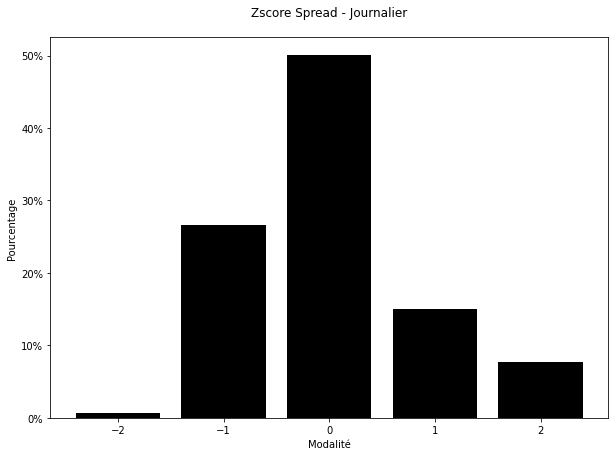

In [37]:
plt.figure(figsize=(10,7))
labels, counts = np.unique(modalites_opt_daily, return_counts=True)
counts = counts / len(modalites_opt_daily)
plt.bar(labels, counts, align='center', color = 'black')
plt.gca().set_xticks(labels)
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.title('Zscore Spread - Journalier\n')
plt.ylabel('Pourcentage')
plt.xlabel('Modalité')
plt.show()

## Data Initial Balance

In [38]:
dataFrame_IB = pd.read_table("Data/dataIB.csv", sep = ";", engine = 'python')
dataFrame_IB = dataFrame_IB.rename(columns={"spread" : "Spread"})

In [39]:
depth = 14

In [40]:
moyenneMob_IB = [moyenne_mobile(k, 1, list(dataFrame_IB.Spread), depth) for k in range(len(dataFrame_IB))]

In [41]:
ecartType_IB = [(variance_mobile(k, list(dataFrame_IB.Spread), moyenneMob_IB, depth))**0.5 for k in range(len(dataFrame_IB))]

In [42]:
opt_a1_IB, opt_a2_IB = opt_coeff(dataFrame_IB, moyenneMob_IB, ecartType_IB)

In [43]:
print("a1 optimal Initial balance = " + str(opt_a1_IB) + ", a2 optimal Initial Balance = " + str(opt_a2_IB))

a1 optimal Initial balance = 0.6900000000000001, a2 optimal Initial Balance = 1.8000000000000012


In [44]:
modalites_opt_IB = [modalite_5classes(dataFrame_IB, k, opt_a1_IB, opt_a2_IB, moyenneMob_IB, ecartType_IB) for k in range(len(dataFrame_IB))]
for k in range(-2, 3):
    print(str(modalites_opt_IB.count(k)/len(dataFrame_IB)*100) + "%")

0.5134788189987163%
27.086007702182286%
49.93581514762516%
14.976465554129225%
7.488232777064613%


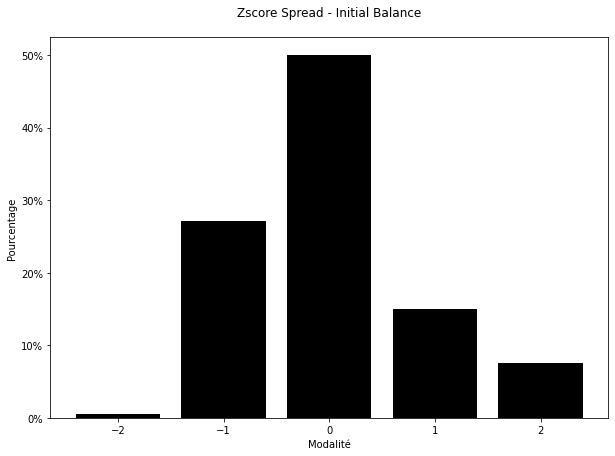

In [45]:
plt.figure(figsize=(10,7))
labels, counts = np.unique(modalites_opt_IB, return_counts=True)
counts = counts / len(modalites_opt_IB)
plt.bar(labels, counts, align='center', color = 'black')
plt.gca().set_xticks(labels)
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.title('Zscore Spread - Initial Balance\n')
plt.ylabel('Pourcentage')
plt.xlabel('Modalité')
plt.show()

## Data 5 minutes

In [73]:
dataFrame_5min = pd.read_table(r"./Data/FDAXM22-EUREX 5Min.csv", sep = ";", engine = 'python')
for col in dataFrame_5min.columns:
    if col[0] == " ":
        dataFrame_5min = dataFrame_5min.rename(columns={col : col[1:]})
dataFrame_5min['Spread'] = dataFrame_5min.High - dataFrame_5min.Low

In [74]:
depth = 14

In [75]:
tmpDF = pd.read_table(r'moyenneMobileSpread.csv', sep = ";", engine = 'python')
moyenneMob_5min = tmpDF['MoyenneMobileSpread5min']
ecartType_5min = tmpDF['EcartTypeMobileSpread5min']

In [76]:
opt_a1_5min, opt_a2_5min = opt_coeff(dataFrame_5min, moyenneMob_5min, ecartType_5min)

In [77]:
print("a1 optimal 5 min = " + str(opt_a1_5min) + ", a2 optimal 5 min = " + str(opt_a2_5min))

a1 optimal 5 min = 0.7000000000000001, a2 optimal 5 min = 1.990000000000001


In [78]:
modalites_opt_5min = [modalite_5classes(dataFrame_5min, k, opt_a1_5min, opt_a2_5min, moyenneMob_5min, ecartType_5min) for k in range(len(dataFrame_5min))]
for k in range(-2, 3):
    print(str(modalites_opt_5min.count(k)/len(dataFrame_5min)*100) + "%")

0.4833565246817398%
28.554905412128363%
50.119323906955124%
14.991880923579668%
5.850533232655102%


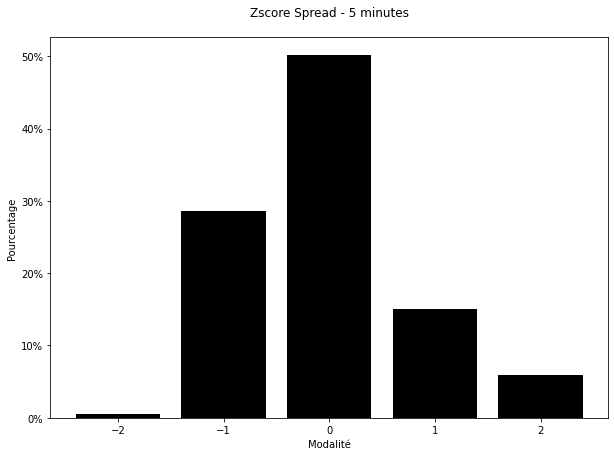

In [79]:
plt.figure(figsize=(10,7))
labels, counts = np.unique(modalites_opt_5min, return_counts=True)
counts = counts / len(modalites_opt_5min)
plt.bar(labels, counts, align='center', color = 'black')
plt.gca().set_xticks(labels)
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.title('Zscore Spread - 5 minutes\n')
plt.ylabel('Pourcentage')
plt.xlabel('Modalité')
plt.show()

# ZScore Volume

In [46]:
def modaliteVol_3classes(df, k, a1, moy, ecart):
    if df.iloc[k].Volume < moy[k] - a1*ecart[k]:
        return -1
    if df.iloc[k].Volume > moy[k] + a1*ecart[k]:
        return 1
    return 0

In [47]:
def modaliteVol_5classes(df, k, a1, a2, moy, ecart):
    if df.iloc[k].Volume < moy[k] - a2*ecart[k]:
        return -2
    if df.iloc[k].Volume < moy[k] - a1*ecart[k]:
        return -1
    if df.iloc[k].Volume > moy[k] + a2*ecart[k]:
        return 2
    if df.iloc[k].Volume > moy[k] + a1*ecart[k]:
        return 1
    return 0

In [48]:
def modaliteVol_7classes(df, k, a1, a2, a3, moy, ecart):
    if df.iloc[k].Volume < moy[k] - a3*ecart[k]:
        return -3
    if df.iloc[k].Volume < moy[k] - a2*ecart[k]:
        return -2
    if df.iloc[k].Volume < moy[k] - a1*ecart[k]:
        return -1
    if df.iloc[k].Volume > moy[k] + a3*ecart[k]:
        return 3
    if df.iloc[k].Volume > moy[k] + a2*ecart[k]:
        return 2
    if df.iloc[k].Volume > moy[k] + a1*ecart[k]:
        return 1
    return 0

In [49]:
def count_modalites_vol_3classes(df, a1, moy, ecart):
    modalites = [modaliteVol_3classes(df, k, a1, moy, ecart) for k in range(len(df))]
    counts = [modalites.count(i)/len(df) for i in range(-1, 2)]
    return counts

In [50]:
def count_modalites_vol_5classes(df, a1, a2, moy, ecart):
    modalites = [modaliteVol_5classes(df, k, a1, a2, moy, ecart) for k in range(len(df))]
    counts = [modalites.count(i)/len(df) for i in range(-2, 3)]
    return counts

In [51]:
def count_modalites_vol_7classes(df, a1, a2, a3, moy, ecart):
    modalites = [modaliteVol_7classes(df, k, a1, a2, a3, moy, ecart) for k in range(len(df))]
    counts = [modalites.count(i)/len(df) for i in range(-3, 4)]
    return counts

In [52]:
max_a1_vol = 1
max_a2_vol = 2
max_a3_vol = 3

In [53]:
def opt_coeff_vol_a1(df, moy, ecart):
    opt_a1 = 0
    minDistance = 2
    for a1 in np.arange(0, max_a1_vol, 0.01):
        counts = count_modalites_vol_3classes(df, a1, moy, ecart)
        if abs(counts[1] - 0.50) <= minDistance:
            minDistance = abs(counts[1] - 0.50)
            opt_a1 = a1
    return opt_a1

In [54]:
def opt_coeff_vol_a2(df, moy, ecart, a1):
    opt_a2 = 0
    minDistance = 2
    for a2 in np.arange(a1+0.01, max_a2_vol, 0.01):
        counts = count_modalites_vol_5classes(df, a1, a2, moy, ecart)
        if abs(counts[3] - 0.15) <= minDistance:
            minDistance = abs(counts[3] - 0.15)
            opt_a2 = a2
    return opt_a2

In [55]:
def opt_coeff_vol_a3(df, moy, ecart, a1, a2):
    opt_a3 = 0
    minDistance = 2
    for a3 in np.arange(a2+0.01, max_a3_vol, 0.01):
        counts = count_modalites_vol_7classes(df, a1, a2, a3, moy, ecart)
        if abs(counts[5] - 0.8) <= minDistance:
            minDistance = abs(counts[5] - 0.8)
            opt_a3 = a3
    return opt_a3

In [56]:
def opt_coeff_vol(df, moy, ecart):
    opt_a1 = opt_coeff_vol_a1(df, moy, ecart)
    print(opt_a1)
    opt_a2 = opt_coeff_vol_a2(df, moy, ecart, opt_a1)
    print(opt_a2)
    opt_a3 = opt_coeff_vol_a3(df, moy, ecart, opt_a1, opt_a2)
    
    return opt_a1, opt_a2, opt_a3

## Data Journalière

In [57]:
dataFrame_daily = pd.read_table(r"./Data/DailyData_VolumeProfile.csv", sep = ";", engine = 'python')
dataFrame_daily = dataFrame_daily.rename(columns={"spread" : "Spread"})

In [58]:
depth = 14

In [59]:
moyenneMobVol_daily = [moyenne_mobile(k, 1, list(dataFrame_daily.Volume), depth) for k in range(len(dataFrame_daily))]

In [60]:
ecartTypeVol_daily = [(variance_mobile(k, list(dataFrame_daily.Volume), moyenneMobVol_daily, depth))**0.5 for k in range(len(dataFrame_daily))]

In [61]:
opt_a1_vol_daily, opt_a2_vol_daily, opt_a3_vol_daily = opt_coeff_vol(dataFrame_daily, moyenneMobVol_daily, ecartTypeVol_daily)

0.73
1.6000000000000008


In [62]:
print("a1 optimal volume journalier = " + str(opt_a1_vol_daily))
print("a2 optimal volume journalier = " + str(opt_a2_vol_daily))
print("a3 optimal volume journalier = " + str(opt_a3_vol_daily))

a1 optimal volume journalier = 0.73
a2 optimal volume journalier = 1.6000000000000008
a3 optimal volume journalier = 2.990000000000002


In [63]:
modalites_opt_vol_daily = [modaliteVol_7classes(dataFrame_daily, k, opt_a1_vol_daily, opt_a2_vol_daily, opt_a3_vol_daily, moyenneMobVol_daily, ecartTypeVol_daily) for k in range(len(dataFrame_daily))]
for k in range(-3, 4):
    print(str(modalites_opt_vol_daily.count(k)/len(dataFrame_daily)*100) + "%")

0.04286326618088298%
5.486498071153021%
20.53150450064295%
50.23574796399486%
15.002143163309045%
8.401200171453064%
0.30004286326618085%


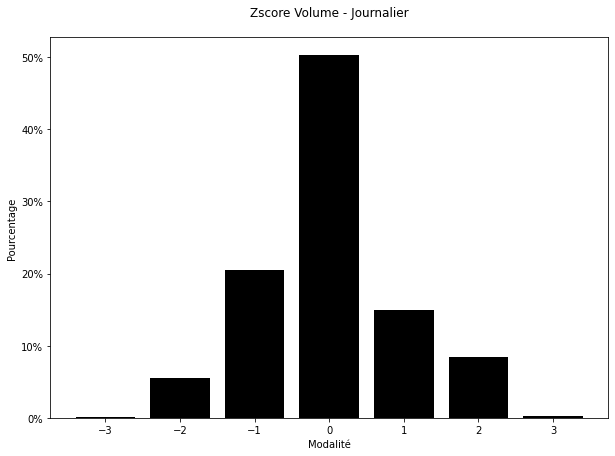

In [64]:
plt.figure(figsize=(10,7))
labels, counts = np.unique(modalites_opt_vol_daily, return_counts=True)
counts = counts / len(modalites_opt_vol_daily)
plt.bar(labels, counts, align='center', color = 'black')
plt.gca().set_xticks(labels)
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.title('Zscore Volume - Journalier\n')
plt.ylabel('Pourcentage')
plt.xlabel('Modalité')
plt.show()

## Data Initial Balance

In [65]:
dataFrame_IB = pd.read_table("Data/dataIB.csv", sep = ";", engine = 'python')
dataFrame_IB = dataFrame_IB.rename(columns={"spread" : "Spread"})

In [66]:
depth = 14

In [67]:
moyenneMobVol_IB = [moyenne_mobile(k, 1, list(dataFrame_IB.Volume), depth) for k in range(len(dataFrame_IB))]

In [68]:
ecartTypeVol_IB = [(variance_mobile(k, list(dataFrame_IB.Volume), moyenneMobVol_IB, depth))**0.5 for k in range(len(dataFrame_IB))]

In [69]:
opt_a1_vol_IB, opt_a2_vol_IB, opt_a3_vol_IB = opt_coeff_vol(dataFrame_IB, moyenneMobVol_IB, ecartTypeVol_IB)

0.65
1.6900000000000008


In [70]:
print("a1 optimal volume Initial Balance = " + str(opt_a1_vol_IB))
print("a2 optimal volume Initial Balance = " + str(opt_a2_vol_IB))
print("a3 optimal volume Initial Balance = " + str(opt_a3_vol_IB))

a1 optimal volume Initial Balance = 0.65
a2 optimal volume Initial Balance = 1.6900000000000008
a3 optimal volume Initial Balance = 2.990000000000002


In [71]:
modalites_opt_vol_IB = [modaliteVol_7classes(dataFrame_IB, k, opt_a1_vol_IB, opt_a2_vol_IB, opt_a3_vol_IB, moyenneMobVol_IB, ecartTypeVol_IB) for k in range(len(dataFrame_IB))]
for k in range(-3, 4):
    print(str(modalites_opt_vol_IB.count(k)/len(dataFrame_IB)*100) + "%")

0.0%
2.139495079161318%
25.54557124518614%
49.63628583654258%
15.019255455712452%
6.418485237483954%
1.2409071459135643%


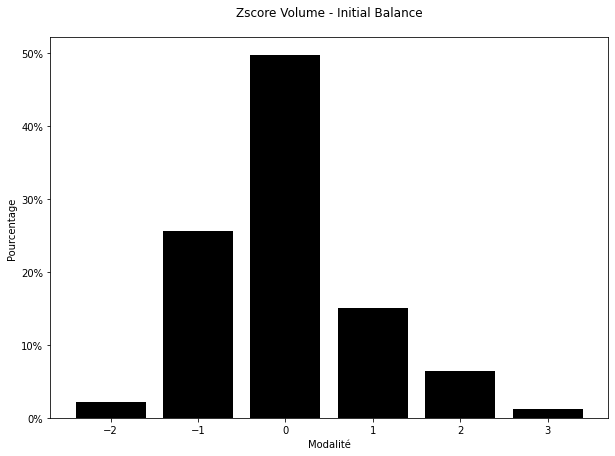

In [72]:
plt.figure(figsize=(10,7))
labels, counts = np.unique(modalites_opt_vol_IB, return_counts=True)
counts = counts / len(modalites_opt_vol_IB)
plt.bar(labels, counts, align='center', color = 'black')
plt.gca().set_xticks(labels)
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.title('Zscore Volume - Initial Balance\n')
plt.ylabel('Pourcentage')
plt.xlabel('Modalité')
plt.show()

## Data 5 minutes

In [80]:
dataFrame_5min = pd.read_table(r"./Data/FDAXM22-EUREX 5Min.csv", sep = ";", engine = 'python')
for col in dataFrame_5min.columns:
    if col[0] == " ":
        dataFrame_5min = dataFrame_5min.rename(columns={col : col[1:]})
dataFrame_5min['Spread'] = dataFrame_5min.High - dataFrame_5min.Low

In [81]:
depth = 14

In [82]:
tmpDF = pd.read_table(r'mobileVolume.csv', sep = ";", engine = 'python')
moyenneMobVol_5min = tmpDF['MoyenneMobileVolume5min']
ecartTypeVol_5min = tmpDF['EcartTypeMobileVolume5min']

In [83]:
opt_a1_vol_5min, opt_a2_vol_5min, opt_a3_vol_5min = opt_coeff_vol(dataFrame_5min, moyenneMobVol_5min, ecartTypeVol_5min)

In [84]:
print("a1 optimal volume 5 minutes = " + str(opt_a1_vol_5min))
print("a2 optimal volume 5 minutes = " + str(opt_a2_vol_5min))
print("a3 optimal volume 5 minutes = " + str(opt_a3_vol_5min))

a1 optimal volume 5 minutes = 0.73
a2 optimal volume 5 minutes = 1.99
a3 optimal volume 5 minutes = 2.99


In [85]:
modalites_opt_vol_5min = [modaliteVol_7classes(dataFrame_5min, k, opt_a1_vol_5min, opt_a2_vol_5min, opt_a3_vol_5min, moyenneMobVol_5min, ecartTypeVol_5min) for k in range(len(dataFrame_5min))]
for k in range(-3, 4):
    print(str(modalites_opt_vol_5min.count(k)/len(dataFrame_5min)*100) + "%")

0.0010101494768688397%
0.17071526159083392%
28.145794873996476%
50.22690482624166%
13.922385164944783%
4.488599200466689%
3.0445905232826824%


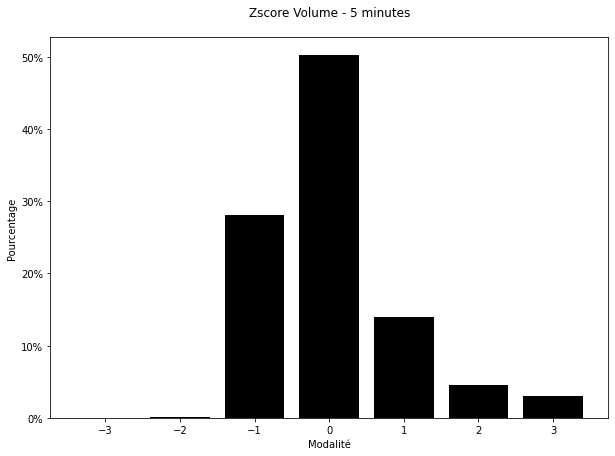

In [86]:
plt.figure(figsize=(10,7))
labels, counts = np.unique(modalites_opt_vol_5min, return_counts=True)
counts = counts / len(modalites_opt_vol_5min)
plt.bar(labels, counts, align='center', color = 'black')
plt.gca().set_xticks(labels)
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.title('Zscore Volume - 5 minutes\n')
plt.ylabel('Pourcentage')
plt.xlabel('Modalité')
plt.show()

## Enlever les jours sans IB

In [87]:
indices_jours_a_enlever = []
for i in range(len(dataFrame_IB)):
    date = dataFrame_IB.iloc[i].Date
    if len(dataFrame_daily.loc[dataFrame_daily.Date == date]) == 0:
        print(date)
        indices_jours_a_enlever.append(i)

22/04/2013
17/02/2015
20/07/2015
16/03/2018


In [88]:
if len(modalites_opt_IB) > len(modalites_opt_daily):
    for index in indices_jours_a_enlever:
        modalites_opt_IB.pop(index)
        
if len(modalites_opt_vol_IB) > len(modalites_opt_vol_daily):
    for index in indices_jours_a_enlever:
        modalites_opt_vol_IB.pop(index)

In [89]:
print(len(modalites_opt_daily))
print(len(modalites_opt_IB))
print(len(modalites_opt_5min))
print(len(modalites_opt_vol_daily))
print(len(modalites_opt_vol_IB))
print(len(modalites_opt_vol_5min))

2333
2333
395981
2333
2333
395981


## Stocker les résultats

In [90]:
df_resultats = pd.DataFrame()

In [91]:
df_resultats['ZScore Spread Daily'] = pd.Series(modalites_opt_daily)
df_resultats['ZScore Spread IB'] = pd.Series(modalites_opt_IB)

df_resultats['ZScore Volume Daily'] = pd.Series(modalites_opt_vol_daily)
df_resultats['ZScore Volume IB'] = pd.Series(modalites_opt_vol_IB)

In [93]:
df_resultats.to_csv(r'ZScoresCalcules.csv', sep = ';', index=False)

In [94]:
df_resultats_5min = pd.DataFrame()

In [95]:
df_resultats_5min['ZScore Spread 5min'] = pd.Series(modalites_opt_5min)
df_resultats_5min['ZScore Volume 5min'] = pd.Series(modalites_opt_vol_5min)

In [96]:
df_resultats_5min.to_csv(r'ZScoresCalcules5min.csv', sep = ';', index=False)